<a href="https://colab.research.google.com/github/NigelGoh16/Crowd_Counting_Model/blob/main/Crowd_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r '/content/gdrive/MyDrive/ML' kaggle.json

! cp -r /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/gdrive


In [13]:
!cp -r '/content/gdrive/MyDrive/ML/crowd_counting_simpleCNN.h5' /content/model.h5

In [14]:
import tensorflow as tf
model = tf.keras.models.load_model("/content/model.h5")

In [2]:
! wget "https://raw.githubusercontent.com/NigelGoh16/Sentiment_Analytics/master/app.py"

--2023-11-17 10:57:30--  https://raw.githubusercontent.com/NigelGoh16/Sentiment_Analytics/master/app.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12645 (12K) [text/plain]
Saving to: ‘app.py’

app.py              100%[===================>]  12.35K  --.-KB/s    in 0s      

2023-11-17 10:57:30 (35.4 MB/s) - ‘app.py’ saved [12645/12645]



In [7]:
! kaggle datasets download -d fmena14/crowd-counting

 99% 1.17G/1.18G [00:13<00:00, 80.3MB/s]
100% 1.18G/1.18G [00:13<00:00, 94.2MB/s]


In [8]:
import zipfile

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/crowd-counting.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [9]:
import pandas as pd

df = pd.read_csv('/content/labels.csv')

In [5]:
import tensorflow_hub as hub

# Data Exploration

In [10]:
df

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41
...,...,...
1995,1996,27
1996,1997,27
1997,1998,25
1998,1999,26


In [11]:
import numpy as np

image_data = np.load('images.npy')
labels = np.load('labels.npy')

In [8]:
len(image_data), len(labels)

(2000, 2000)

In [9]:
image_data.shape, labels.shape

((2000, 480, 640, 3), (2000, 1))

In [10]:
image_data.dtype, labels.dtype

(dtype('uint8'), dtype('uint8'))

# Viewing

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def view_random_image(target_dir):
  random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
  random_image_path = target_dir + "/" + random_image # create the choosen random image path
  img = mpimg.imread(random_image_path) # read in the chosen target image
  plt.imshow(img) # plot the target image
  plt.title(f"Random image")
  plt.axis(False); # turn off the axes

def random_image(target_dir):
  random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
  random_image_path = target_dir + "/" + random_image # create the choosen random image path
  img = mpimg.imread(random_image_path) # read in the chosen target image
  return img

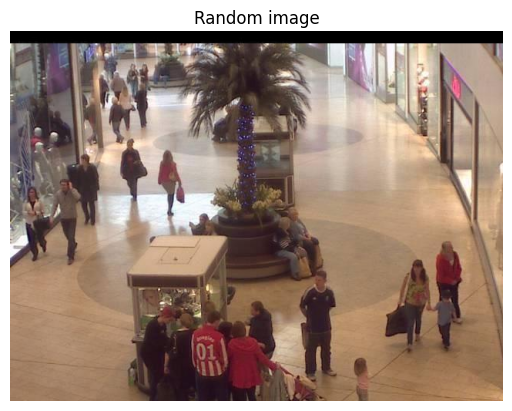

In [12]:
view_random_image("/content/frames/frames")

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
view_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name ="data_augmentation")

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

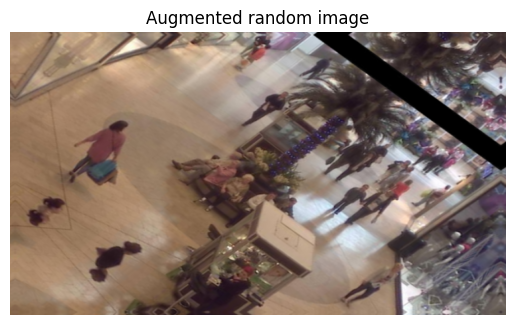

In [18]:
# Augment the image
img = random_image("/content/frames/frames")
augmented_img = view_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image")
plt.axis(False);

In [19]:
# Checking the max and min after rescaling data
img = random_image("/content/frames/frames")
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
np.max(augmented_img), np.min(augmented_img)

(1.0, 0.0)

# Preprocessing

In [20]:
# Define the preprocess_img function
def preprocess_img(image, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32)

In [21]:
lamb_preproc = lambda x: tf.cast((tf.image.resize(x, [224, 224])), tf.float32)

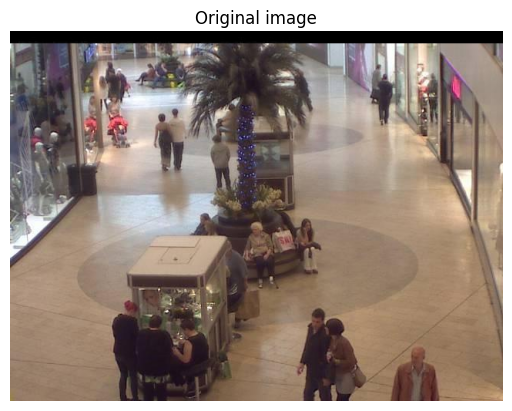

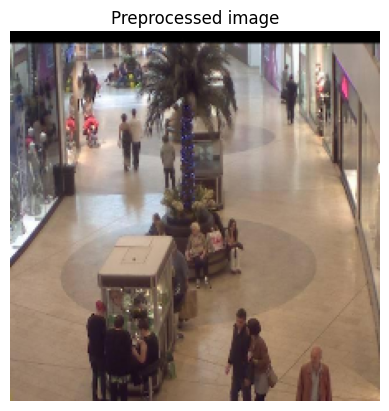

In [22]:
# Viewing Preprocessed Images
img = random_image("/content/frames/frames")
pre_image= preprocess_img(img)

plt.figure()
plt.imshow(img)
plt.title(f"Original image")
plt.axis(False);

plt.figure()
plt.imshow(tf.squeeze(pre_image)/255.)
plt.title(f"Preprocessed image")
plt.axis(False);

In [23]:
image_dataset = lamb_preproc(image_data)
# Initialize empty lists for tensors
image_dataset_tensors = []
labels_tensors = []

# Convert each array in image_dataset to a tensor and append to image_dataset_tensors
for image_array in image_dataset:
    image_dataset_tensors.append(tf.constant(image_array))

# Convert each array in labels to a tensor and append to labels_tensors
for label_array in labels:
    labels_tensors.append(tf.constant(labels))

In [20]:
len(labels_tensors), len(image_dataset_tensors)

(2000, 2000)

In [21]:
image_dataset_tensors[0].shape

TensorShape([224, 224, 3])

In [24]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(image_dataset_tensors,
                                                                            labels,
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [25]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels))

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Apply the preprocess_img function using the map function
# train_dataset = train_dataset.map(preprocess_img)
# valid_dataset = valid_dataset.map(preprocess_img)

# Functions

In [14]:
def create_model(model_url, num_classes=1):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224)+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='linear', name='output_layer') # create our own output layer
  ])

  return model

In [15]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  MSE = history.history['MSE']
  val_MSE = history.history['val_MSE']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_MAE_loss')
  plt.plot(epochs, val_loss, label='val_MSE_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, MSE, label='training_MSE')
  plt.plot(epochs, val_MSE, label='val_MSE')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [59]:
def random_pred_and_plot(model):
  """
  Takes a random image, makes a prediction on it with
  a trained model and plots the image with prediction and label.
  """
  # Import the target image and preprocess it
  img = random.choice(os.listdir("/content/frames/frames"))
  label = labels[int(img[4:-4])]
  img_clear = mpimg.imread("/content/frames/frames/" + img)
  img = preprocess_img(img_clear)

  # Make a prediction
  pred = tf.round(model_0.predict(tf.expand_dims(img, axis=0)))
  # Plot the image and predicted class
  plt.imshow(img_clear)
  plt.title(f"Prediction: {pred}, Label: {label}")
  plt.axis(False);

In [81]:
def pred_and_plot(filename, model):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  img_clear = mpimg.imread("/content/" + filename)
  img = preprocess_img(img_clear)

  # Make a prediction
  pred = tf.round(model_0.predict(tf.expand_dims(img, axis=0)))
  # Plot the image and predicted class
  plt.imshow(img_clear)
  plt.title(f"Prediction: {pred}")
  plt.axis(False);

# Model 0

In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, AvgPool2D

model_0 = Sequential([
  Conv2D(20, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(20, 3, activation='relu'),
  AvgPool2D(),
  Conv2D(20, 6, activation='relu'),
  AvgPool2D(),
  Conv2D(20, 1, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='linear')
])

# Compile the model
model_0.compile(loss="MAE",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["MAE", "MSE"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_1 = model_0.fit(train_dataset,
                        epochs=20,
                        steps_per_epoch=len(train_dataset),
                        validation_data=valid_dataset,
                        # Go through less of the validation data so epochs are faster (we want faster experiments!)
                        validation_steps=int(0.25 * len(valid_dataset)))

Epoch 1/20
57/57 [==============================] - 4s 35ms/step - loss: 9.9848 - MAE: 9.9848 - MSE: 258.4186 - val_loss: 5.4239 - val_MAE: 5.4239 - val_MSE: 48.2038
Epoch 2/20
57/57 [==============================] - 2s 33ms/step - loss: 5.6674 - MAE: 5.6674 - MSE: 51.9088 - val_loss: 5.7045 - val_MAE: 5.7045 - val_MSE: 54.4078
Epoch 3/20
57/57 [==============================] - 2s 34ms/step - loss: 4.9768 - MAE: 4.9768 - MSE: 39.9971 - val_loss: 4.5144 - val_MAE: 4.5144 - val_MSE: 29.1388
Epoch 4/20
57/57 [==============================] - 2s 34ms/step - loss: 4.3858 - MAE: 4.3858 - MSE: 31.4404 - val_loss: 4.2473 - val_MAE: 4.2473 - val_MSE: 25.9921
Epoch 5/20
57/57 [==============================] - 2s 30ms/step - loss: 3.8174 - MAE: 3.8174 - MSE: 23.8766 - val_loss: 3.9436 - val_MAE: 3.9436 - val_MSE: 21.7420
Epoch 6/20
57/57 [==============================] - 2s 30ms/step - loss: 3.2361 - MAE: 3.2361 - MSE: 17.5996 - val_loss: 4.0420 - val_MAE: 4.0420 - val_MSE: 27.1736
Epoch 7/2

<Axes: >

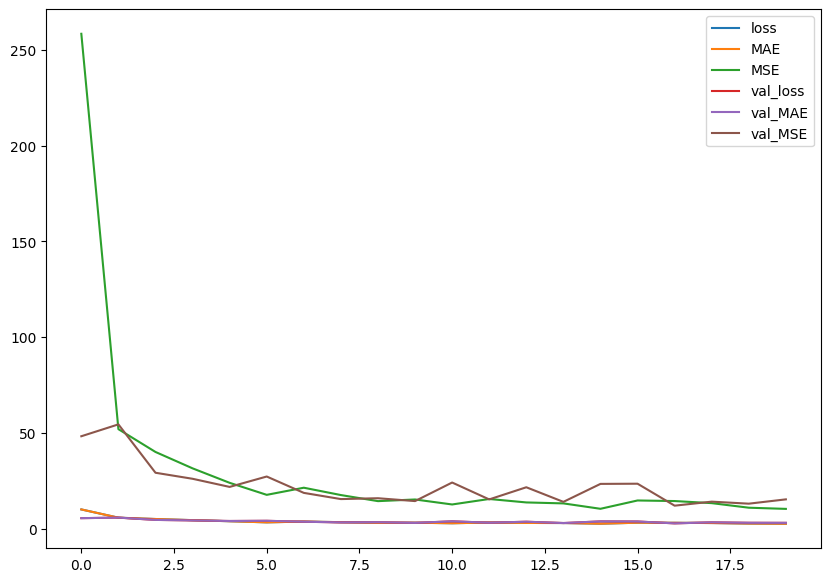

In [75]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

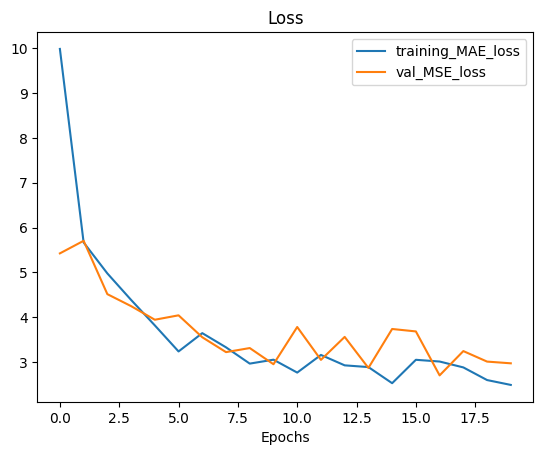

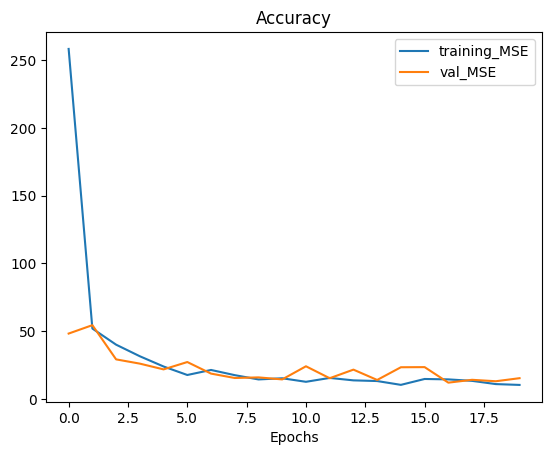

In [76]:
# Check out the loss curves of model_4
plot_loss_curves(history_1)

1/1 [==============================] - 0s 21ms/step


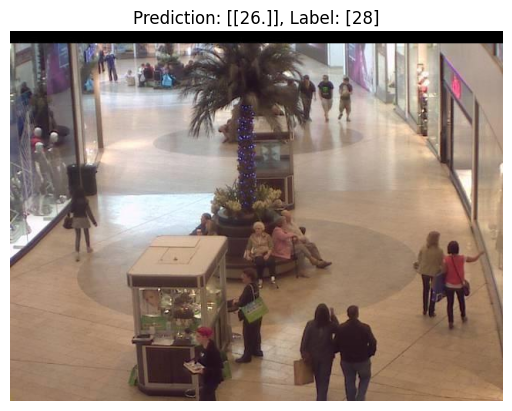

In [80]:
random_pred_and_plot(model_0)

In [73]:
!wget -q https://previews.123rf.com/images/janifest/janifest1903/janifest190300028/120392305-people-crowd-walking-in-the-business-centre-and-shopping-mall-entrance-view-from-the-top.jpg

1/1 [==============================] - 0s 28ms/step


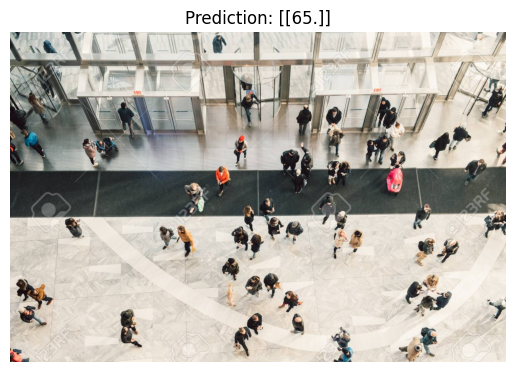

In [86]:
pred_and_plot("crowd1.jpg", model_0)

In [87]:
tf.keras.models.save_model(
    model_0,
    "/content/crowd_counting_simpleCNN.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

<ipython-input-87-9dca35594c91>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(


In [89]:
!cp crowd_counting_simpleCNN.h5 /content/gdrive/MyDrive/ML

# To be Continued

## ResNet Model 1

In [29]:
# Create model
resnet_model = create_model("https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/152-feature-vector/versions/2")

# Compile
resnet_model.compile(loss='MAE',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['MAE', 'MSE'])

In [30]:
history_2 = resnet_model.fit(train_dataset,
                        epochs=20,
                        steps_per_epoch=len(train_dataset),
                        validation_data=valid_dataset,
                        # Go through less of the validation data so epochs are faster (we want faster experiments!)
                        validation_steps=int(0.25 * len(valid_dataset)))

Epoch 1/20
57/57 [==============================] - 27s 255ms/step - loss: 34.5881 - MAE: 34.5881 - MSE: 2886.3123 - val_loss: 15.3318 - val_MAE: 15.3318 - val_MSE: 334.2587
Epoch 2/20
57/57 [==============================] - 12s 218ms/step - loss: 20.3264 - MAE: 20.3264 - MSE: 656.7934 - val_loss: 12.2409 - val_MAE: 12.2409 - val_MSE: 212.8865
Epoch 3/20
57/57 [==============================] - 12s 217ms/step - loss: 23.9052 - MAE: 23.9052 - MSE: 852.3764 - val_loss: 19.3709 - val_MAE: 19.3709 - val_MSE: 489.5338
Epoch 4/20
57/57 [==============================] - 12s 219ms/step - loss: 20.3536 - MAE: 20.3536 - MSE: 648.2741 - val_loss: 13.3104 - val_MAE: 13.3104 - val_MSE: 227.9467
Epoch 5/20
57/57 [==============================] - 13s 223ms/step - loss: 23.4821 - MAE: 23.4821 - MSE: 855.5778 - val_loss: 77.7016 - val_MAE: 77.7016 - val_MSE: 6111.8975
Epoch 6/20
57/57 [==============================] - 13s 223ms/step - loss: 40.5566 - MAE: 40.5566 - MSE: 2561.8850 - val_loss: 13.308

In [31]:
# Check out the layers in our model
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              58331648  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 58333697 (222.53 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58331648 (222.52 MB)
_________________________________________________________________


<Axes: >

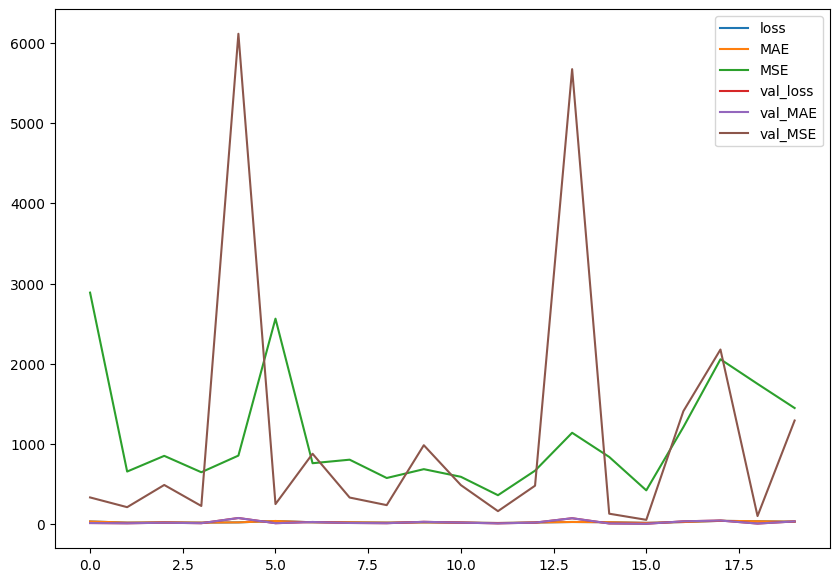

In [32]:
pd.DataFrame(history_2.history).plot(figsize=(10, 7))

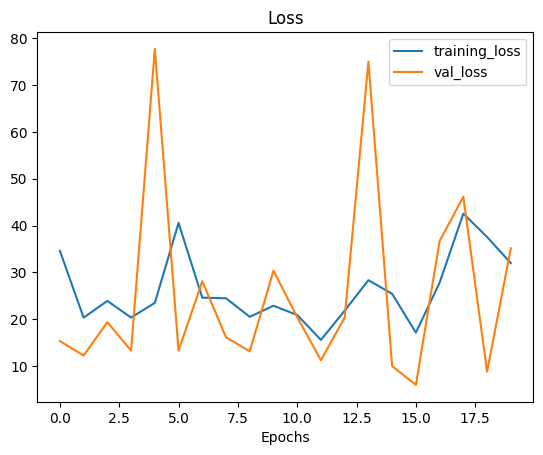

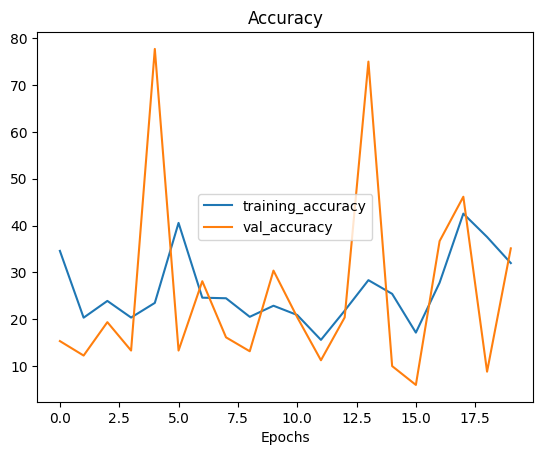

In [33]:
plot_loss_curves(history_2)

## Multiple model Training